In [76]:
from timeit import default_timer as timer
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib 
import matplotlib.ticker as ticker
from itertools import cycle, islice


In [4]:
df=pd.read_csv('card transactions.csv')
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


In [5]:
df.shape

(96753, 10)

## Data cleaning

### remove all but P, remove the single high purchsase record outlier

In [6]:
# Remove all but P: keep P, Delete A, D, Y
df['Transtype'].value_counts()

P    96398
A      181
D      173
Y        1
Name: Transtype, dtype: int64

In [7]:
remove=['A', 'D', 'Y']
for i in df.index:
    if df.loc[i,'Transtype'] in remove:
        df=df.drop(index=i)
df.shape

(96398, 10)

In [8]:
# Remove the single high purchase record outlier
df.sort_values('Amount', ascending=False).head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
52714,52715,5142189135,2006-07-13,NaN,INTERMEXICO,NaN,NaN,P,3102045.53,0
47339,47340,5142275225,2006-06-22,NaN,INTERSOL,NaN,NaN,P,47900.00,0
59516,59517,5142138135,2006-08-03,900009045549,KRACKELER SCIENTIFIC,NY,12202.0,P,30372.46,1
80886,80887,5142152857,2006-10-11,NaN,CANYON ELECTRIC,NV,89102.0,P,28392.84,1
89673,89674,5142183210,2006-11-29,NaN,CRUCIAL TECH./MICRON,ID,83642.0,P,27218.00,0


In [9]:
df=df.drop(index=52714)
df.shape

(96397, 10)

### Fill in missing data

In [10]:
df.isnull().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             3198
Merch description       0
Merch state          1020
Merch zip            4300
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

#### Merch state

In [11]:
# Create a dictionary for mapping zipcode and state
zip_state={}
for index, zip5 in df[df['Merch zip'].notnull()]['Merch zip'].items():
    if zip5 not in zip_state:
        zip_state[zip5]= df.loc[index,'Merch state']

In [12]:
# Create a dictionary for mapping merchdaise number and state
merchnum_state = {}
for index, merchnum in df[df['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_state :
        merchnum_state [merchnum] = df.loc[index, 'Merch state']


In [13]:
# Create a dictionary for mapping merchandise state and state
merchdes_state = {}
for index, merchdes in df[df['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_state :
        merchdes_state [merchdes] = df.loc[index, 'Merch state']


In [14]:
# fill in by mapping with zip, merchnum and merch description
df['Merch state'] = df['Merch state'].fillna(df['Merch zip'].map(zip_state))
df['Merch state'] = df['Merch state'].fillna(df['Merchnum'].map(merchnum_state))
df['Merch state'] = df['Merch state'].fillna(df['Merch description'].map(merchdes_state))


In [15]:
# assign unknown for adjustments transactions
df['Merch state'] = df['Merch state'].mask(df['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
df['Merch state'] = df['Merch state'].mask(df['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [16]:
df['Merch state']=df['Merch state'].fillna('unknown')

In [17]:
df.isnull().sum()


Recnum                  0
Cardnum                 0
Date                    0
Merchnum             3198
Merch description       0
Merch state             0
Merch zip            4300
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

#### Merch zip

In [18]:
# Creating dictionary for merchandise number with zipcode
merchnum_zip = {}
for index, merchnum in df[df['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_zip :
        merchnum_zip [merchnum] = df.loc[index, 'Merch zip']


In [19]:
# Creating dictionary for merchandise name and zipcode
merchdes_zip = {}
for index, merchdes in df[df['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_zip :
        merchdes_zip [merchdes] = df.loc[index, 'Merch zip']


In [20]:
# fill in by mapping with merchnum and merch description
df['Merch zip'] = df['Merch zip'].fillna(df['Merchnum'].map(merchnum_zip))
df['Merch zip'] = df['Merch zip'].fillna(df['Merch description'].map(merchdes_zip))


In [21]:
#assign unknown for adjustments transactions
df['Merch zip'] = df['Merch zip'].mask(df['Merch zip'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
df['Merch zip'] = df['Merch zip'].mask(df['Merch zip'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')


In [22]:
df['Merch zip']=df['Merch zip'].fillna('unknown')

In [23]:
df.isnull().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             3198
Merch description       0
Merch state             0
Merch zip               0
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

#### Merchnum

In [24]:
# Creating dictionary for mercndise and merchandis number
merchdes_merchnum = {}
for index, merchdes in df[df['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_merchnum :
        merchdes_merchnum[merchdes] = df.loc[index, 'Merchnum']


In [25]:
# fill in by mapping with Merch description
df['Merchnum'] = df['Merchnum'].fillna(df['Merch description'].map(merchdes_merchnum))


In [26]:
# assign unknown for adjustments transactions
df['Merchnum'] = df['Merchnum'].mask(df['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
df['Merchnum'] = df['Merchnum'].mask(df['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [27]:
df['Merchnum']=df['Merchnum'].fillna('unknown')

In [28]:
df.isnull().sum()

Recnum               0
Cardnum              0
Date                 0
Merchnum             0
Merch description    0
Merch state          0
Merch zip            0
Transtype            0
Amount               0
Fraud                0
dtype: int64

In [29]:
df.dtypes

Recnum                 int64
Cardnum                int64
Date                  object
Merchnum              object
Merch description     object
Merch state           object
Merch zip             object
Transtype             object
Amount               float64
Fraud                  int64
dtype: object

## Creating Variables

#### Use entity to create velocity variable

In [30]:
df['Cardnum']= df['Cardnum'].astype(str)
df['Amount']= df['Amount'].astype(str)
df['Merch zip']= df['Merch zip'].astype(str)

In [31]:
# Make some new entities for variables
df['card_merch']= df.Cardnum + df.Merchnum
df['card_state']= df.Cardnum + df['Merch state']
df['card_zip']= df.Cardnum + df['Merch zip']
df['card_transtype']= df.Cardnum + df.Transtype
df['Merch_address']= df['Merch state'] + df['Merch zip']
df['Merchnum_state'] = df['Merchnum'] + df['Merch state']
df['Merchnum_zip'] = df['Merchnum'] + df['Merch zip']
df['Date_state']= df['Date']+ df['Merch state']
df['Date_zip']= df['Date']+ df['Merch zip']
df['Amount_date']= df['Amount'] + df['Date']
df['Amount_description'] = df.Amount + df['Merch description']
df['Amount_state']= df.Amount + df['Merch state']
df['Amount_zip']= df['Amount'] + df['Merch zip']
df['Amount_transtype']= df['Amount'] + df['Transtype']
df.head()


,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Merch_address,Merchnum_state,Merchnum_zip,Date_state,Date_zip,Amount_date,Amount_description,Amount_state,Amount_zip,Amount_transtype
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,TN38118.0,5509006296254TN,550900629625438118.0,2006-01-01TN,2006-01-0138118.0,3.622006-01-01,3.62FEDEX SHP 12/23/09 AB#,3.62TN,3.6238118.0,3.62P
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,MA1803.0,61003026333MA,610030263331803.0,2006-01-01MA,2006-01-011803.0,31.422006-01-01,31.42SERVICE MERCHANDISE #81,31.42MA,31.421803.0,31.42P
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,MD20706.0,4503082993600MD,450308299360020706.0,2006-01-01MD,2006-01-0120706.0,178.492006-01-01,178.49OFFICE DEPOT #191,178.49MD,178.4920706.0,178.49P
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,TN38118.0,5509006296254TN,550900629625438118.0,2006-01-01TN,2006-01-0138118.0,3.622006-01-01,3.62FEDEX SHP 12/28/09 AB#,3.62TN,3.6238118.0,3.62P
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,TN38118.0,5509006296254TN,550900629625438118.0,2006-01-01TN,2006-01-0138118.0,3.622006-01-01,3.62FEDEX SHP 12/23/09 AB#,3.62TN,3.6238118.0,3.62P


In [32]:
df['Date']= pd.to_datetime(df['Date'])
df['Amount']=df['Amount'].astype(float)
df.dtypes

Recnum                         int64
Cardnum                       object
Date                  datetime64[ns]
Merchnum                      object
Merch description             object
Merch state                   object
Merch zip                     object
Transtype                     object
Amount                       float64
Fraud                          int64
card_merch                    object
card_state                    object
card_zip                      object
card_transtype                object
Merch_address                 object
Merchnum_state                object
Merchnum_zip                  object
Date_state                    object
Date_zip                      object
Amount_date                   object
Amount_description            object
Amount_state                  object
Amount_zip                    object
Amount_transtype              object
dtype: object

In [33]:
df1= df.copy()
final= df.copy()
df1['check_date']= df1.Date
df1['check_record']= df1.Recnum
final.shape

(96397, 24)

In [34]:
entities= df.columns
entities

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud',
       'card_merch', 'card_state', 'card_zip', 'card_transtype',
       'Merch_address', 'Merchnum_state', 'Merchnum_zip', 'Date_state',
       'Date_zip', 'Amount_date', 'Amount_description', 'Amount_state',
       'Amount_zip', 'Amount_transtype'],
      dtype='object')

In [36]:
import time
import timeit
import datetime as dt
start = timeit.default_timer()
entities= ['Cardnum', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip',
       'card_merch', 'card_state', 'card_transtype', 'Merch_address',
       'Merchnum_state', 'Merchnum_zip', 'Amount_transtype', 'Date_state',
       'Date_zip', 'Amount_description', 'card_zip', 'Amount_date',
       'Amount_state', 'Amount_zip']
for entity in entities:    
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()    
    ## Day-since variables:   
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')   
    ## Frequency & Amount variables:   
    for time in [0,1,3,7,14,30]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
        final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')

print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))


Run time for the last entity ----------------- 147.63760101600002s

Cardnum_day_since ---> Done
Cardnum_count_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_count_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_count_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_count_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_count_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_count_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Run time for the last entity ----------------- 27.974217014999994s

Merchnum_day_since ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_count_3 ---> Done
Merchnum amount variables over past 3 ---> Done
Merchnum_count_7 ---> Done
Merchnum amount variables over past 7 ---> Done
Merchnum_count_14 ---> Done
Merchnum amount variables over past 1

In [38]:
final.shape

(96397, 1069)

In [39]:
# Temporary save the 1069 columns data
final.to_csv('final_vars.csv')

In [3]:
df_1= pd.read_csv('final_vars.csv')
df_1.head()

,Unnamed: 0,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,...,Amount_zip_actual/toal_14,Amount_zip_count_30,Amount_zip_avg_30,Amount_zip_max_30,Amount_zip_med_30,Amount_zip_total_30,Amount_zip_actual/avg_30,Amount_zip_actual/max_30,Amount_zip_actual/med_30,Amount_zip_actual/toal_30
0,0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,...,1.000000,1,3.62,3.62,3.62,3.62,1.0,1.0,1.0,1.000000
1,1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,...,1.000000,1,31.42,31.42,31.42,31.42,1.0,1.0,1.0,1.000000
2,2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,...,1.000000,1,178.49,178.49,178.49,178.49,1.0,1.0,1.0,1.000000
3,3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,...,0.500000,2,3.62,3.62,3.62,7.24,1.0,1.0,1.0,0.500000
4,4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,...,0.333333,3,3.62,3.62,3.62,10.86,1.0,1.0,1.0,0.333333


In [4]:
df1= df_1.copy()
final= df_1.copy()
df1['check_date']= df1.Date
df1['check_record']= df1.Recnum
final.shape

(96397, 1070)

In [5]:

# velocity change variables
import time
import timeit
import datetime as dt
start = timeit.default_timer()
entities= ['Cardnum', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip',
       'card_merch', 'card_state', 'card_transtype', 'Merch_address',
       'Merchnum_state', 'Merchnum_zip', 'Amount_transtype', 'Date_state',
       'Date_zip', 'Amount_description', 'card_zip', 'Amount_date',
       'Amount_state', 'Amount_zip']
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30']:
            final[ent + '_count_' + d + '_by_' + dd] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/float(dd)
            
print('run time: {}s'.format(timeit.default_timer() - start))


run time: 2.6849613420000082s


#### Banford Law variable

In [ ]:
df_1= pd.read_csv('final_vars.csv')
df1= df_1.copy()
final= df_1.copy()
df1['check_date']= df1.Date
df1['check_record']= df1.Recnum
final.shape

In [8]:
# Create Benford's Law
cleaned_data= df1[df1['Merch description'].str.match(r"[Ff][Ex][Dd][Ee][Xx]")== False].copy()
cleaned_data['Amount']= cleaned_data['Amount'].astype(str)

In [9]:
def n_low(df1):
    return ((df1['Amount'].str.extract(r"([1-9])")=='1') | (df1['Amount'].str.extract(r"([1-9])")=='2')).sum()

In [18]:
cardnums = cleaned_data.groupby('Cardnum').apply(n_low)
cardnums['n'] = cleaned_data.groupby('Cardnum')['Amount'].count()
cardnums['n_low']= cleaned_data.groupby('Cardnum').apply(n_low)
cardnums = cardnums[['n', 'n_low']]
cardnums['n_high'] = cardnums['n'] - cardnums['n_low']


In [19]:
cardnums['n_low']= cardnums['n_low'].replace(0,1)
cardnums['n_high'] = cardnums['n_high'].replace(0,1)

In [20]:
cardnums['R']= 1.096 * cardnums['n_low']/ cardnums['n_high']
cardnums['1/R'] = 1/cardnums['R']
cardnums['U'] = cardnums [['R', '1/R']].max(axis=1)

In [21]:
cardnums['t'] = (cardnums['n']-15)/3
cardnums['U*'] = 1+ ((cardnums['U']-1)/(1+ np.exp(1)**-cardnums['t']))

In [22]:
cardnums.sort_values('U*', ascending = False)[0:40].to_csv('Top 40 Cardnum.csv')

In [23]:
merchnums= cleaned_data.groupby('Merchnum').apply(n_low)
merchnums['n']= cleaned_data.groupby('Merchnum')['Amount'].count()
merchnums['n_low']= cleaned_data.groupby('Merchnum').apply(n_low)
merchnums= merchnums[['n', 'n_low']]
merchnums['n_high']= merchnums['n']-merchnums['n_low']

In [24]:
merchnums['n_low']= merchnums['n_low'].replace(0,1)
merchnums['n_high'] = merchnums['n_high'].replace(0,1)

In [25]:
merchnums['R']= 1.096 * merchnums['n_low']/ merchnums['n_high']
merchnums['1/R'] = 1/merchnums['R']
merchnums['U'] = merchnums [['R', '1/R']].max(axis=1)

In [26]:
merchnums['t'] = (merchnums['n']-15)/3
merchnums['U*'] = 1+ ((merchnums['U']-1)/(1+ np.exp(1)**-merchnums['t']))

In [27]:
merchnums.sort_values('U*', ascending = False)[0:40].to_csv('Top 40 Merchnum.csv')

In [30]:
cardnums.sort_values('U*', ascending = False)

,n,n_low,n_high,R,1/R,U,t,U*
Cardnum,,,,,,,,
5142253356,66,61,5,13.371200,0.074788,13.371200,17.000000,13.371199
5142299705,28,25,3,9.133333,0.109489,9.133333,4.333333,9.027976
5142197563,149,15,134,0.122687,8.150852,8.150852,44.666667,8.150852
5142194617,38,5,33,0.166061,6.021898,6.021898,7.666667,6.019548
5142288241,14,1,13,0.084308,11.861314,11.861314,-0.333333,5.533836
...,...,...,...,...,...,...,...,...
5142163835,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
5142264859,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
5142299970,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894


In [153]:
cardnums.head()

,n,n_low,n_high,R,1/R,U,t,U*
Cardnum,,,,,,,,
5142110002,1,1,1,1.096,0.912409,1.096000,-4.666667,1.000894
5142110081,4,1,4,0.274,3.649635,3.649635,-3.666667,1.066041
5142110313,3,2,1,2.192,0.456204,2.192000,-4.000000,1.021440
5142110402,11,3,8,0.411,2.433090,2.433090,-1.333333,1.298955
5142110434,1,1,1,1.096,0.912409,1.096000,-4.666667,1.000894


In [154]:
cardnum_dic={}
for i in cardnums.index:
    value=cardnums.loc[i,'U*']
    cardnum_dic[i]=value
cardnum_dic

{5142110002: 1.0008943320971264,
 5142110081: 1.0660406341087767,
 5142110313: 1.0214395622748131,
 5142110402: 1.298954799501315,
 5142110434: 1.0008943320971264,
 5142110651: 1.0312461165764801,
 5142110691: 1.2898194051377396,
 5142110749: 1.0106844613939316,
 5142110909: 2.230411559704762,
 5142111097: 1.1437222955801254,
 5142111125: 2.2810218838307383,
 5142111372: 1.0628698362380815,
 5142111572: 1.2017090973824154,
 5142111587: 1.1560025457500256,
 5142111703: 1.2525713513092662,
 5142111930: 1.1725002326214184,
 5142112110: 1.0106844613939316,
 5142112347: 1.0299724433580237,
 5142112444: 1.269437837183291,
 5142112551: 1.107406369213951,
 5142112611: 1.0339458289094356,
 5142112805: 1.0227196873323532,
 5142112822: 1.0644768819194568,
 5142112858: 1.0012435578429468,
 5142112936: 1.0644552633127558,
 5142113016: 1.0959968771763544,
 5142113088: 1.0701816235484805,
 5142113162: 1.3029030971980347,
 5142113192: 2.8677698061211756,
 5142113193: 1.5952398763280664,
 5142113198: 1

In [ ]:
df=pd.read_csv('final_vars.csv')

In [155]:
df['Cardnum_U*'] = df['Cardnum'].map(cardnum_dic)
df.head()

,Unnamed: 0,Unnamed: 0.1,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,...,Amount_zip_count_0_by_14,Amount_zip_count_0_by_30,Amount_zip_count_1_by_7,Amount_zip_count_1_by_14,Amount_zip_count_1_by_30,Cardnum U*,U*,dayofweek,Risk,Cardnum_U*
0,0,0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,...,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN,Sunday,0.02242,2.178008
1,1,1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,...,0.071429,0.033333,0.142857,0.071429,0.033333,1.604857,1.000894,Sunday,0.02242,1.604857
2,2,2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,...,0.071429,0.033333,0.142857,0.071429,0.033333,2.368143,1.025818,Sunday,0.02242,2.368143
3,3,3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,...,0.071429,0.033333,0.142857,0.071429,0.033333,1.044105,NaN,Sunday,0.02242,1.044105
4,4,4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,...,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN,Sunday,0.02242,2.178008


In [159]:
merchnums.head()

,n,n_low,n_high,R,1/R,U,t,U*
Merchnum,,,,,,,,
0,56,29,27,1.177185,0.849484,1.177185,13.666667,1.177185
003100006NOT6,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
004740006ABC6,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
005590006PNB6,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
014430619 14,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894


In [161]:
merchnums_dic={}
for i in merchnums.index:
    value=merchnums.loc[i,'U*']
    merchnums_dic[i]=value
merchnums_dic

{'0': 1.1771849795634672,
 '003100006NOT6': 1.0008943320971264,
 '004740006ABC6': 1.0008943320971264,
 '005590006PNB6': 1.0008943320971264,
 '014430619  14': 1.0008943320971264,
 '014938913  51': 1.0008943320971264,
 '014948837  52': 1.0106844613939316,
 '014988879  18': 1.0008943320971264,
 '016560006NOT0': 1.0008943320971264,
 '017670006NOT0': 1.002392744958123,
 '018252152  57': 1.0008943320971264,
 '018990006NOT0': 1.043299368919804,
 '020130006EDU0': 1.0214395622748131,
 '025950005PSS6': 1.0008943320971264,
 '028450006NOT0': 1.0008943320971264,
 '028600006NOT0': 1.0008943320971264,
 '032630006NOT0': 1.0012435578429468,
 '035390089PSS0': 1.0012435578429468,
 '035390089PSS6': 1.0154408432165896,
 '039320006APC0': 1.0008943320971264,
 '039320006APC6': 1.0008943320971264,
 '044140006ALB0': 1.0312461165764801,
 '044140006ALB6': 1.0008943320971264,
 '047010006ABC0': 1.0012435578429468,
 '047070006NOT6': 1.0008943320971264,
 '05-0500900356': 1.057027088168597,
 '05-0506005800': 1.0008943

In [162]:
df['Merch_U*'] = df['Merchnum'].map(merchnums_dic)
df.head()

,Unnamed: 0,Unnamed: 0.1,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,...,Amount_zip_count_0_by_30,Amount_zip_count_1_by_7,Amount_zip_count_1_by_14,Amount_zip_count_1_by_30,Cardnum U*,U*,dayofweek,Risk,Cardnum_U*,Merch_U*
0,0,0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,...,0.033333,0.142857,0.071429,0.033333,2.178008,NaN,Sunday,0.02242,2.178008,NaN
1,1,1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,...,0.033333,0.142857,0.071429,0.033333,1.604857,1.000894,Sunday,0.02242,1.604857,1.000894
2,2,2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,...,0.033333,0.142857,0.071429,0.033333,2.368143,1.025818,Sunday,0.02242,2.368143,1.025818
3,3,3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,...,0.033333,0.142857,0.071429,0.033333,1.044105,NaN,Sunday,0.02242,1.044105,NaN
4,4,4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,...,0.033333,0.142857,0.071429,0.033333,2.178008,NaN,Sunday,0.02242,2.178008,NaN


In [169]:
# Drop the duplicate column
df=df.drop(columns=['Risk'],axis=1)
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Amount_state_count_1_by_14,Amount_state_count_1_by_30,Amount_zip_count_0_by_7,Amount_zip_count_0_by_14,Amount_zip_count_0_by_30,Amount_zip_count_1_by_7,Amount_zip_count_1_by_14,Amount_zip_count_1_by_30,Cardnum_U*,Merch_U*
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.604857,1.000894
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.368143,1.025818
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.044105,NaN
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN


In [170]:
df.shape

(96397, 1185)

In [171]:
df.isnull().sum()

Recnum                          0
Cardnum                         0
Date                            0
Merchnum                        0
Merch description               0
                            ...  
Amount_zip_count_1_by_7         0
Amount_zip_count_1_by_14        0
Amount_zip_count_1_by_30        0
Cardnum_U*                     72
Merch_U*                    11775
Length: 1185, dtype: int64

In [172]:
df.to_csv('final_vars.csv')

#### Risk table variable: fraud for that day of the week 

In [173]:
df=pd.read_csv('final_vars.csv')
df.head()

,Unnamed: 0,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,...,Amount_state_count_1_by_14,Amount_state_count_1_by_30,Amount_zip_count_0_by_7,Amount_zip_count_0_by_14,Amount_zip_count_0_by_30,Amount_zip_count_1_by_7,Amount_zip_count_1_by_14,Amount_zip_count_1_by_30,Cardnum_U*,Merch_U*
0,0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN
1,1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.604857,1.000894
2,2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.368143,1.025818
3,3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.044105,NaN
4,4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN


In [174]:
df.shape

(96397, 1186)

In [175]:
# Create date of week first 
import datetime
df['Date']= pd.to_datetime(df['Date'])
df['dayofweek']=df['Date'].dt.day_name()
df.head()


,Unnamed: 0,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,...,Amount_state_count_1_by_30,Amount_zip_count_0_by_7,Amount_zip_count_0_by_14,Amount_zip_count_0_by_30,Amount_zip_count_1_by_7,Amount_zip_count_1_by_14,Amount_zip_count_1_by_30,Cardnum_U*,Merch_U*,dayofweek
0,0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN,Sunday
1,1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.604857,1.000894,Sunday
2,2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.368143,1.025818,Sunday
3,3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.044105,NaN,Sunday
4,4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN,Sunday


In [176]:
df['dayofweek'].value_counts()

Thursday     19588
Wednesday    18517
Friday       17943
Tuesday      15033
Monday       10176
Saturday     10055
Sunday        5085
Name: dayofweek, dtype: int64

In [177]:
dayofweek=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data={}
for day in dayofweek:
    count=0
    for i in range(len(df)):
        if df.loc[i,"dayofweek"] ==day:
            if df.loc[i,"Fraud"]==1:
                count+=1
    dt=df[(df['dayofweek']==day)]
    risk= round(count/ len(dt),5)           
    data[day]=risk
data

{'Monday': 0.01081,
 'Tuesday': 0.01044,
 'Wednesday': 0.00875,
 'Thursday': 0.00796,
 'Friday': 0.00953,
 'Saturday': 0.0188,
 'Sunday': 0.02242}

In [179]:
df['Risk'] = df['dayofweek'].map(data)
df

,Unnamed: 0,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,...,Amount_zip_count_0_by_7,Amount_zip_count_0_by_14,Amount_zip_count_0_by_30,Amount_zip_count_1_by_7,Amount_zip_count_1_by_14,Amount_zip_count_1_by_30,Cardnum_U*,Merch_U*,dayofweek,Risk
0,0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,...,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN,Sunday,0.02242
1,1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,...,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.604857,1.000894,Sunday,0.02242
2,2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,...,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.368143,1.025818,Sunday,0.02242
3,3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,...,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.044105,NaN,Sunday,0.02242
4,4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,...,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN,Sunday,0.02242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,96392,96749,5142276053,2006-12-31,3500000006160,BEST BUY 00001610,KY,41042.0,P,84.79,...,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.002393,1.000894,Sunday,0.02242
96393,96393,96750,5142225701,2006-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248.0,P,118.75,...,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.137948,1.288057,Sunday,0.02242
96394,96394,96751,5142226486,2006-12-31,4503057341100,"TECH PAC, INC",OH,45150.0,P,363.56,...,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.201338,1.106055,Sunday,0.02242
96395,96395,96752,5142244619,2006-12-31,8834000695412,BUY.COM,CA,92656.0,P,2202.03,...,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.499767,1.029441,Sunday,0.02242


In [180]:
df=df.drop(columns=['Unnamed: 0','dayofweek'])
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Amount_state_count_1_by_30,Amount_zip_count_0_by_7,Amount_zip_count_0_by_14,Amount_zip_count_0_by_30,Amount_zip_count_1_by_7,Amount_zip_count_1_by_14,Amount_zip_count_1_by_30,Cardnum_U*,Merch_U*,Risk
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN,0.02242
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.604857,1.000894,0.02242
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.368143,1.025818,0.02242
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.044105,NaN,0.02242
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN,0.02242


In [181]:
df.to_csv('final_vars.csv')

## Target Encoding

### By Weekday

In [37]:
data={'Day of Week':['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'], 
'Percentage': [0.01081,0.01044,0.00875,0.00796,0.00953,0.0188, 0.02242]}
df=pd.DataFrame.from_dict(data)
df=df.set_index('Day of Week')
df

,Percentage
Day of Week,
Mon,0.01081
Tues,0.01044
Wed,0.00875
Thurs,0.00796
Fri,0.00953
Sat,0.01880
Sun,0.02242


Text(0.5, 1.0, 'Fraud Proportion of Each Weekday')

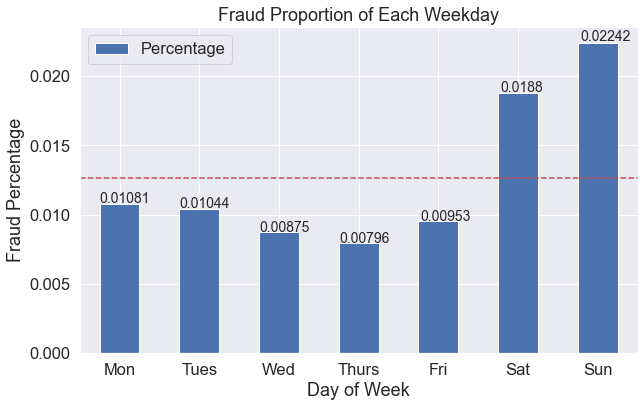

In [45]:
sns.set(font_scale=1.5)

ax=df.plot(kind='bar')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=14)

plt.xticks(rotation='horizontal')
plt.xlabel('Day of Week')
plt.ylabel('Fraud Percentage')
plt.axhline(y=df['Percentage'].mean(), color='r', linestyle='--')
plt.title('Fraud Proportion of Each Weekday')


### By State

In [58]:
df_original=pd.read_csv('create_vars.csv')
df_original.head()

,Unnamed: 0,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,...,Amount_state_count_1_by_30,Amount_zip_count_0_by_7,Amount_zip_count_0_by_14,Amount_zip_count_0_by_30,Amount_zip_count_1_by_7,Amount_zip_count_1_by_14,Amount_zip_count_1_by_30,Cardnum_U*,Merch_U*,Risk
0,0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN,0.02242
1,1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.604857,1.000894,0.02242
2,2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.368143,1.025818,0.02242
3,3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.044105,NaN,0.02242
4,4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN,0.02242


In [59]:
df_original['Merch state'].unique()

array(['TN', 'MA', 'MD', 'OH', 'GA', 'IL', 'TX', 'WA', 'WI', 'NJ', 'FL',
       'NY', 'CA', 'MS', 'VA', 'MO', 'PA', 'NC', 'WV', 'CT', 'KS', 'OR',
       'SC', 'MI', 'MN', 'KY', 'ME', 'CO', 'DC', 'AK', 'IA', 'NH', 'MT',
       'OK', 'unknown', 'NV', 'RI', 'NE', 'AZ', 'NM', 'UT', 'ID', 'SD',
       'AL', 'DE', 'BC', 'LA', 'QC', 'IN', 'ON', 'VT', 'ND', 'AR', 'MB',
       'HI', 'WY', 'PQ', 'NS', 'AB', 'US'], dtype=object)

In [60]:
state=df_original['Merch state'].unique()
data_state={}
for st in state:
    count=0
    for i in range(len(df_original)):
        if df_original.loc[i,"Merch state"] ==st:
            if df_original.loc[i,"Fraud"]==1:
                count+=1
    dt=df_original[(df_original['Merch state']==st)]
    risk= round(count/ len(dt),5)           
    data_state[st]=risk
    print(st,risk)


TN 0.00814
MA 0.00288
MD 0.01519
OH 0.02171
GA 0.001
IL 0.00645
TX 0.01108
WA 0.04212
WI 0.00105
NJ 0.00204
FL 0.0028
NY 0.02181
CA 0.01334
MS 0.0
VA 0.01223
MO 0.00207
PA 0.01734
NC 0.00271
WV 0.0
CT 0.00315
KS 0.00243
OR 0.04702
SC 0.00649
MI 0.00689
MN 0.00213
KY 0.00577
ME 0.0
CO 0.00101
DC 0.01528
AK 0.0
IA 0.0
NH 0.00551
MT 0.0
OK 0.00227
unknown 0.00298
NV 0.00275
RI 0.0
NE 0.0
AZ 0.00289
NM 0.01739
UT 0.03834
ID 0.0
SD 0.01205
AL 0.0058
DE 0.0
BC 0.0
LA 0.0
QC 0.0
IN 0.07925
ON 0.0
VT 0.0
ND 0.0
AR 0.0
MB 0.0
HI 0.0
WY 0.0
PQ 0.0
NS 0.0
AB 0.0
US 0.0


In [63]:
data_state.keys()

dict_keys(['TN', 'MA', 'MD', 'OH', 'GA', 'IL', 'TX', 'WA', 'WI', 'NJ', 'FL', 'NY', 'CA', 'MS', 'VA', 'MO', 'PA', 'NC', 'WV', 'CT', 'KS', 'OR', 'SC', 'MI', 'MN', 'KY', 'ME', 'CO', 'DC', 'AK', 'IA', 'NH', 'MT', 'OK', 'unknown', 'NV', 'RI', 'NE', 'AZ', 'NM', 'UT', 'ID', 'SD', 'AL', 'DE', 'BC', 'LA', 'QC', 'IN', 'ON', 'VT', 'ND', 'AR', 'MB', 'HI', 'WY', 'PQ', 'NS', 'AB', 'US'])

In [72]:
data={'State':data_state.keys(), 'Fraud Percentage':data_state.values() }
df=pd.DataFrame.from_dict(data)
df=df.set_index('State')
df.sort_values("Fraud Percentage",ascending=False).head(20)

,Fraud Percentage
State,
IN,0.07925
OR,0.04702
WA,0.04212
UT,0.03834
NY,0.02181
OH,0.02171
NM,0.01739
PA,0.01734
DC,0.01528


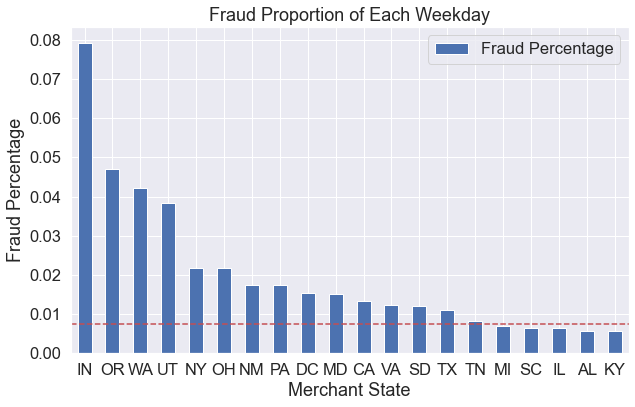

In [81]:
sns.set(font_scale=1.5)

ax=df.sort_values("Fraud Percentage",ascending=False).head(20).plot(kind='bar')

# for p in ax.patches:
#     ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=14)

plt.xticks(rotation='horizontal')
plt.xlabel('Merchant State')
plt.ylabel('Fraud Percentage')
plt.axhline(y=df['Fraud Percentage'].mean(), color='r', linestyle='--')
plt.title('Fraud Proportion of Each Weekday')
